# Metody statystyczne zestaw 3
## Autor Paweł Jelonek

In [72]:
import numpy as np
import matplotlib.pyplot as plt
import concurrent.futures
import threading
import time
import random

from timeit import default_timer as timer
plt.rcParams['figure.figsize']=(20, 10)
plt.rcParams['axes.titlesize']=20

### Symulacja procesu kolejkowego

- Zadania przychodzą w tempie $ \lambda_A $
- Serwer obsługuje zadania w tempie $ \lambda_S $
- Oczekiwany czas pomiędzy przychodzeniem kolejnych zadań $ \mu_A = \dfrac{1}{\lambda_A} $ 
- Średni czas obsługi $ \mu_S = \dfrac{1}{\lambda_S} $ 

In [30]:
lock = threading.Lock()
pos_in_queue = 0

In [31]:
class Entry:
    def __init__(self, id, start_queue, start_time, end_queue = None, end_time = None):
        self.id = id
        self.start_queue = start_queue
        self.end_queue = end_queue
        self.start_time = start_time
        self.end_time = end_time
        
    def fix_time(self, time):
        self.start_time = self.start_time - time
        self.end_time = self.end_time - time
        return self

In [63]:
def produce_entry(task_size: int, delay: float):
    global pos_in_queue
    
    for id in np.arange(task_size):
        time.sleep(delay/1000)
        with lock:
            task_pos_in_queue = pos_in_queue
            pos_in_queue += 1
        
        yield Entry(id, task_pos_in_queue, timer())   

In [201]:
def service_entry(delay, task):
    global pos_in_queue
    
    time.sleep(delay/1000)
    with lock:
        pos_in_queue -= 1 
        task.end_queue = pos_in_queue
    time.sleep(-np.log(random.uniform(0, 1))/(1/(delay/10000))) 
    task.end_time = timer()
    return task

In [193]:
def run_simulation(delay, *args):
    start = timer()
    with concurrent.futures.ThreadPoolExecutor(max_workers=1) as executor:
        executor_list = []
        for task in produce_entry(*args):
            time.sleep(-np.log(random.uniform(0, 1))/(1/(delay/10000)))            
            executor_list.append(executor.submit(service_entry, delay, task))
            
        for task in concurrent.futures.as_completed(executor_list):
            task.result().fix_time(start)
        return sorted([executor.result() for executor in concurrent.futures.as_completed(executor_list)], key=lambda x: x.id)

In [35]:
def extract_data(tasks):
    return [task.start_queue for task in tasks], [task.end_queue for task in tasks], [task.start_time for task in tasks], [task.end_time for task in tasks]

In [36]:
def plot_points(tasks):
    start_queue, end_queue, start_times, end_times = extract_data(tasks)
    
    plt.scatter(start_times, start_queue, color='r')
    plt.scatter(end_times, end_queue, color='b')
    for i, task in enumerate(tasks):
        plt.text(start_times[i], start_queue[i] + max(max(start_queue)/20, 0.05), f'id: {task.id}', fontsize=12)
        plt.text(end_times[i], end_queue[i] - max(max(start_queue)/20, 0.05), f'id: {task.id}', fontsize=12)
    
    plt.xlabel('Czas wykonywania')
    plt.ylabel('Stan kolejki')
    plt.ylim(0, max(start_queue) + 2)
    plt.grid()
    plt.show()

In [37]:
def get_wait_time(tasks):
    return [task.end_time - task.start_time for task in tasks]

def plot_waiting_interval(tasks):
    wait_time = get_wait_time(tasks)
    plt.plot([task.id for task in tasks], wait_time, color='r')
    plt.xlabel('Numer zadania w systemie')
    plt.ylabel('Czas oczekiwania')
    plt.grid()
    plt.ylim(0, max(max(wait_time), 1))
    plt.show()

## Problem A

### Oczekiwany czas między zdarzeniami: $ \mu_A = 200[ms] , \lambda_A = \dfrac{1}{200} $

### Średni czas obsługi:  $ \mu_S = 150[ms] , \lambda_S = \dfrac{1}{150} $

### $ \lambda_A < \lambda_S $ - zadania wykonywane szybciej niż napływają 

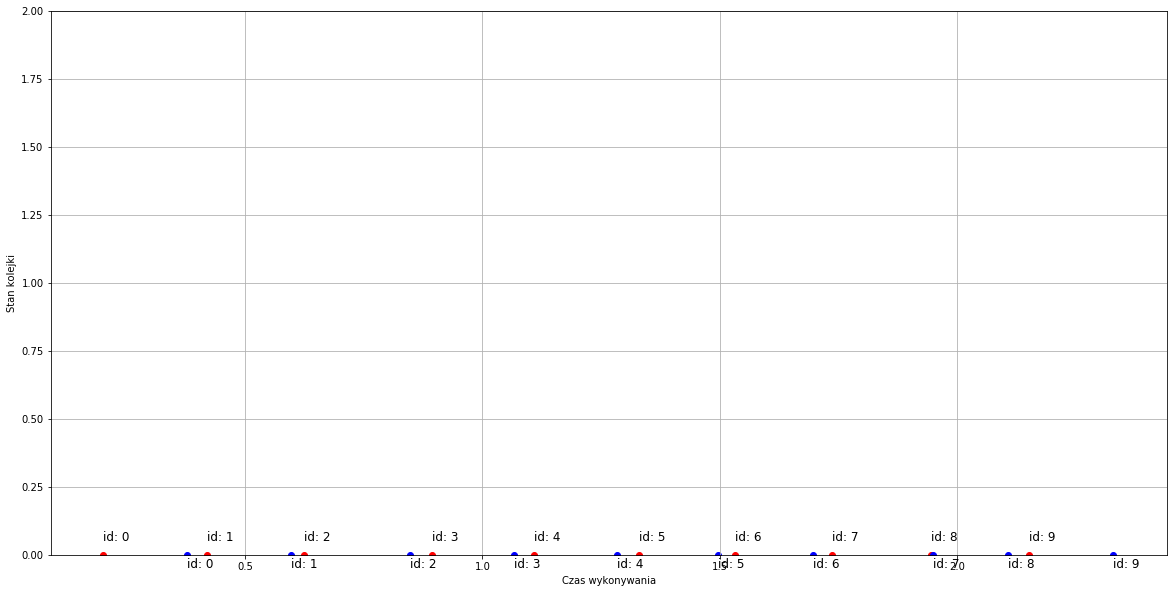

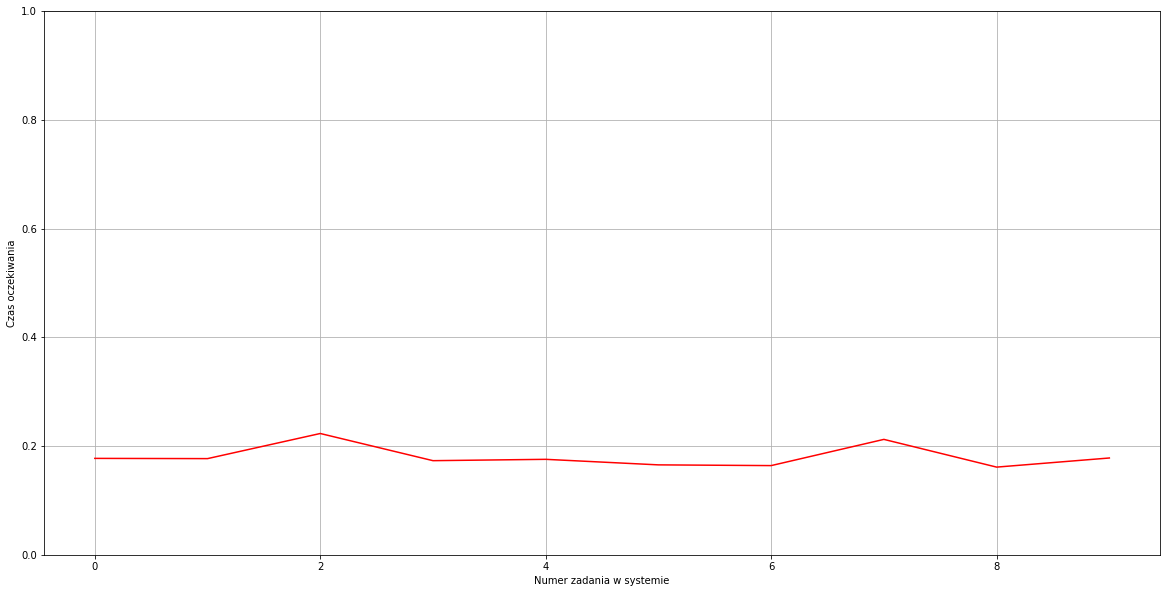

In [208]:
send_delay = 200
service_delay = 150
num_of_tasks = 10
pos_in_queue = 0
tasks = run_simulation(service_delay, num_of_tasks, send_delay)

plot_points(tasks)
plot_waiting_interval(tasks)

### Oczekiwany czas między zdarzeniami: $ \mu_A = 20[ms] , \lambda_A = \dfrac{1}{20} $

### Średni czas obsługi:  $ \mu_S = 100[ms] , \lambda_S = \dfrac{1}{100} $

### $ \lambda_A > \lambda_S $ - zadania wykonywane wolniej niż napływają 

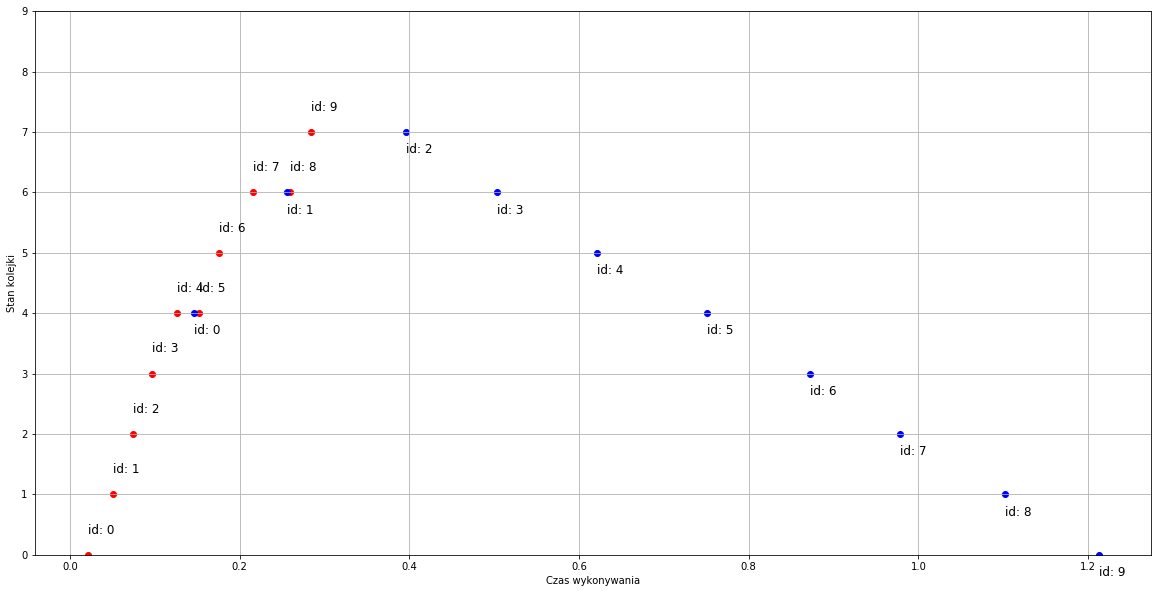

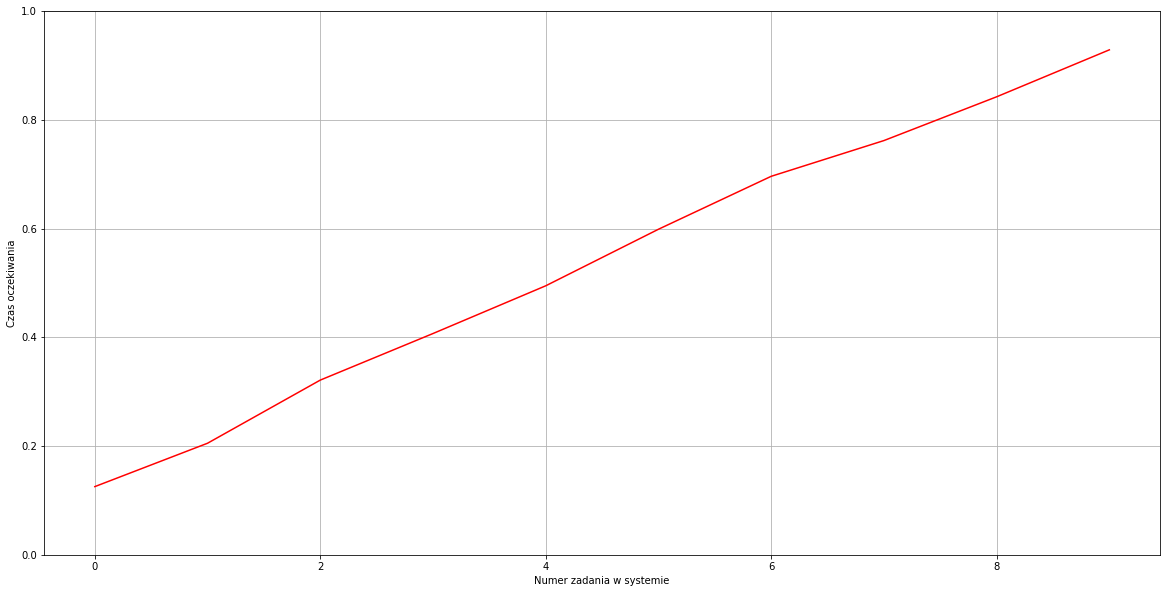

In [209]:
send_delay = 20
service_delay = 100
num_of_tasks = 10
pos_in_queue = 0
tasks = run_simulation(service_delay, num_of_tasks, send_delay)

plot_points(tasks)
plot_waiting_interval(tasks)

### Oczekiwany czas między zdarzeniami: $ \mu_A = 150[ms] , \lambda_A = \dfrac{1}{150} $

### Średni czas obsługi:  $ \mu_S = 150[ms] , \lambda_S = \dfrac{1}{150} $

### $ \lambda_A = \lambda_S $ - zadania wykonywane w takim samym tempie jak napływają 

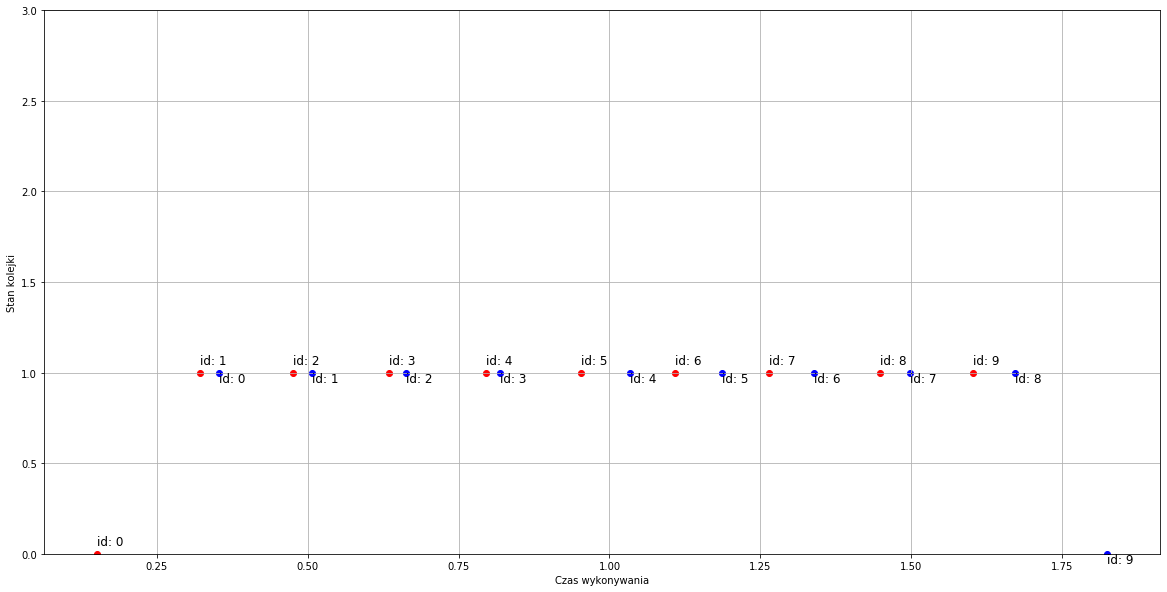

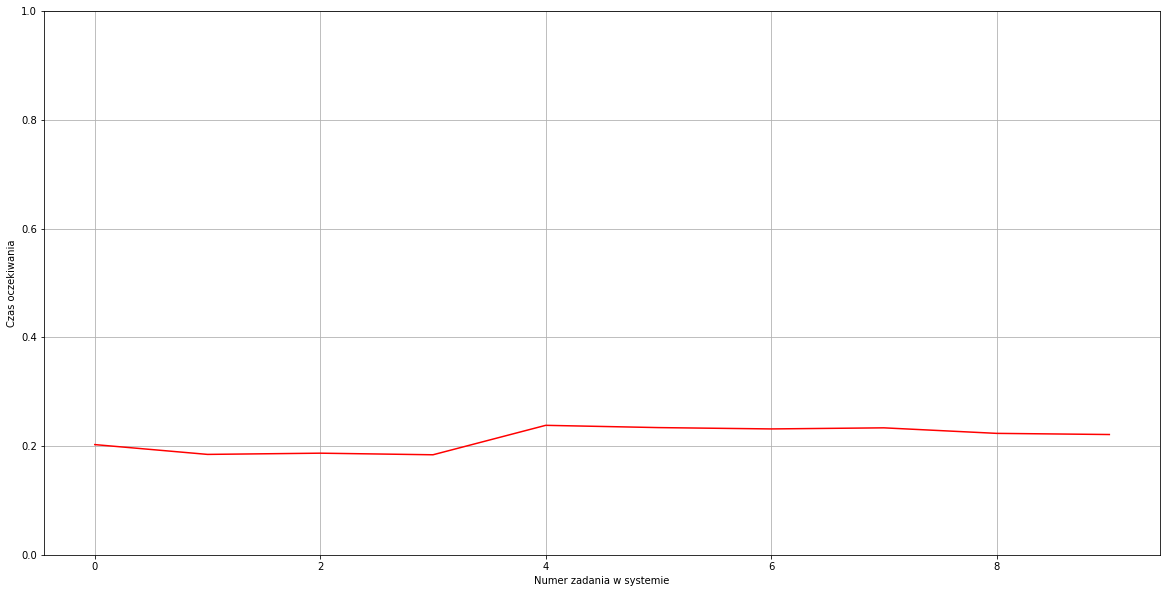

In [210]:
send_delay = 150
service_delay = 150
num_of_tasks = 10
pos_in_queue = 0
tasks = run_simulation(service_delay, num_of_tasks, send_delay)

plot_points(tasks)
plot_waiting_interval(tasks)

## Problem C

### Zatykanie się systemu

### Oczekiwany czas między zdarzeniami: $ \mu_A = 20[ms] , \lambda_A = \dfrac{1}{20} $

### Średni czas obsługi:  $ \mu_S = 100[ms] , \lambda_S = \dfrac{1}{100} $

### $ \lambda_A = \lambda_S $ - zadania wykonywane wolnej niz naplywaja

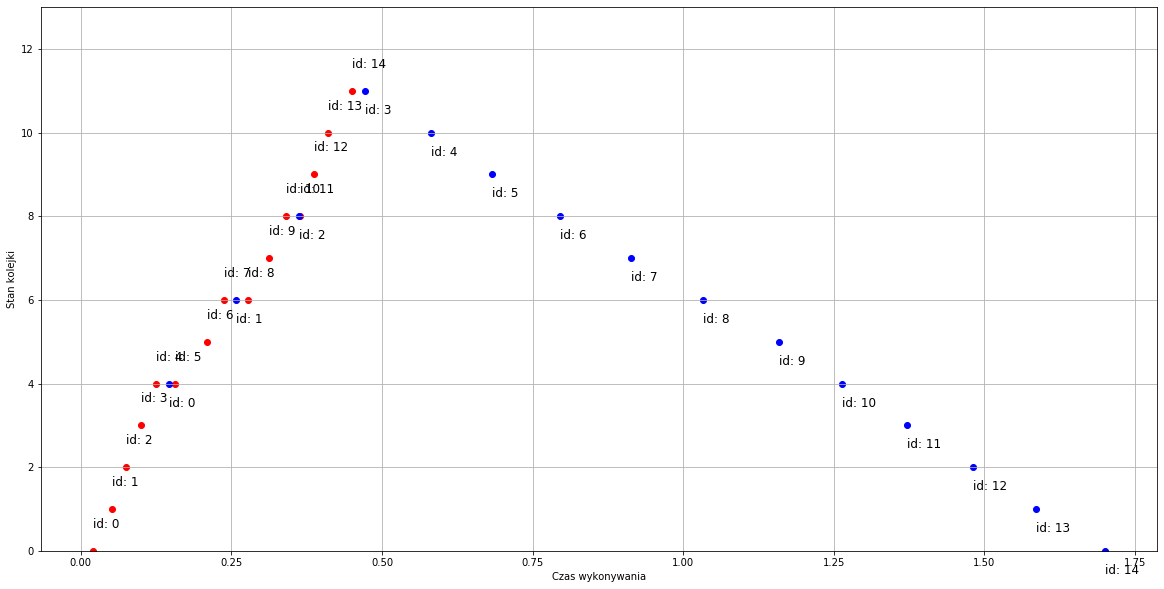

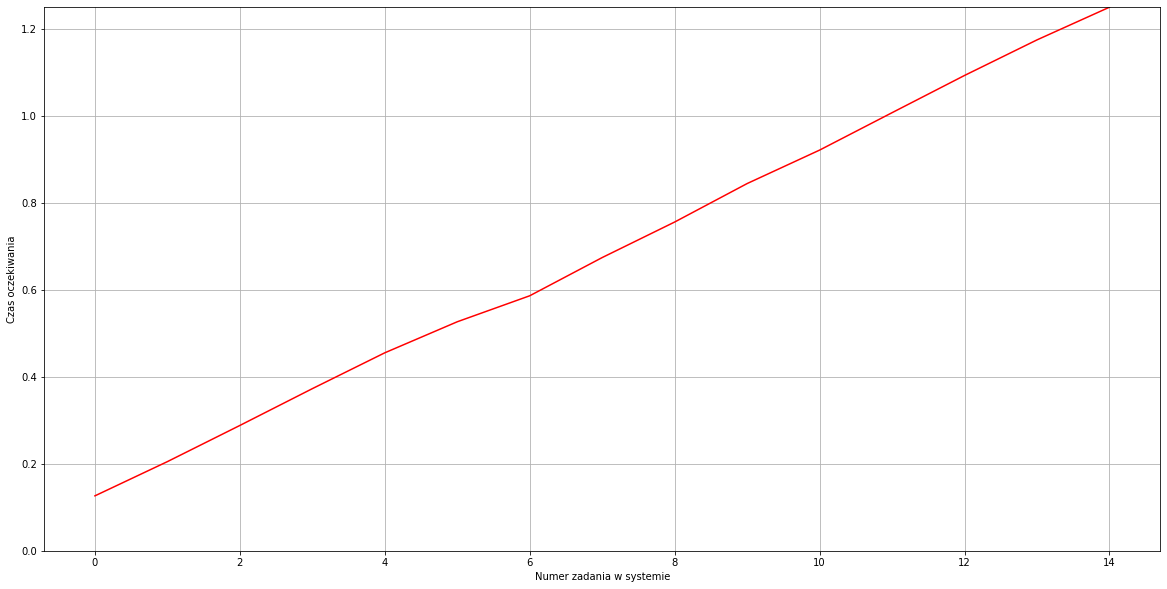

In [211]:
send_delay = 20
service_delay = 100
num_of_tasks = 15
pos_in_queue = 0
tasks = run_simulation(service_delay, num_of_tasks, send_delay)

plot_points(tasks)
plot_waiting_interval(tasks)

### Zależności czasowe
### $(\lambda_A - \lambda_S)t$ - tempo narastania zadań w kolejce

In [212]:
la = 1/20
ls = 1/100

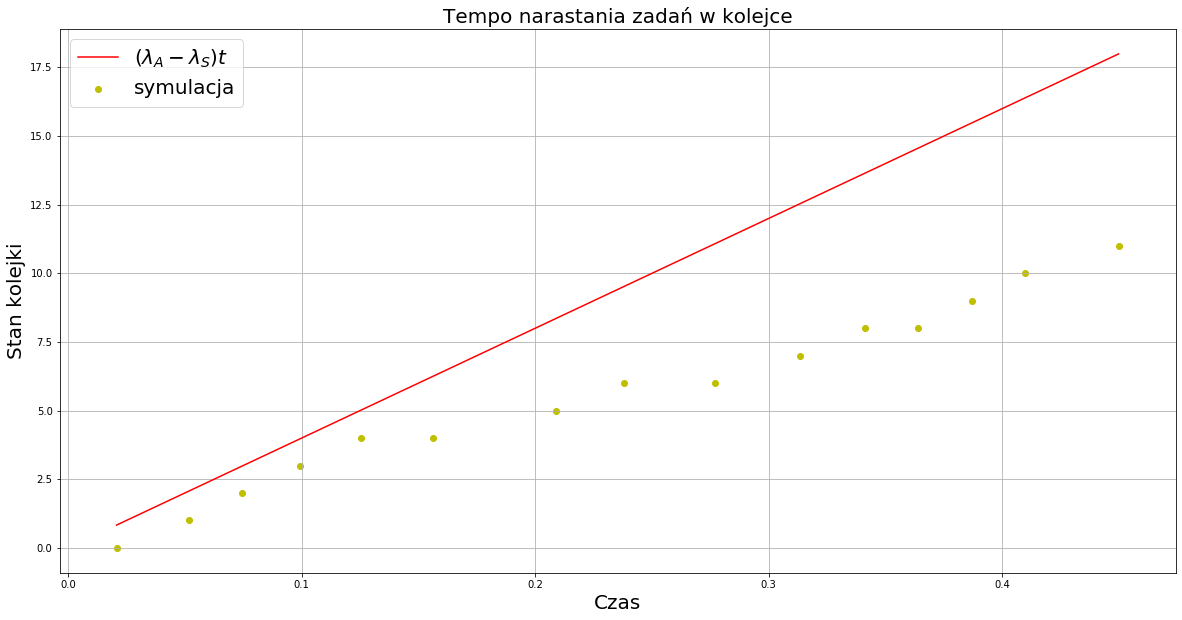

In [213]:
xs_simulation = [task.start_time for task in tasks]
ys_simulation = [task.start_queue for task in tasks]
plt.scatter(xs_simulation, ys_simulation, color='y', label='symulacja')
plt.title('Tempo narastania zadań w kolejce')
plt.xlabel('Czas', fontsize=20)
plt.ylabel('Stan kolejki', fontsize=20)
plt.grid()
xs_theory = [task.start_time for task in tasks]
ys_theory = [(la-ls) * task.start_time * 1000 for task in tasks]
plt.plot(xs_theory, ys_theory, color='r', label='$(\lambda_A - \lambda_S)t$')
plt.legend(loc='upper left', prop={'size': 20})
plt.show()

### $(\dfrac{\lambda_A - \lambda_S}{\lambda_S})t$ - tempo wzrostu czasu oczekiwania na wykonanie zadania

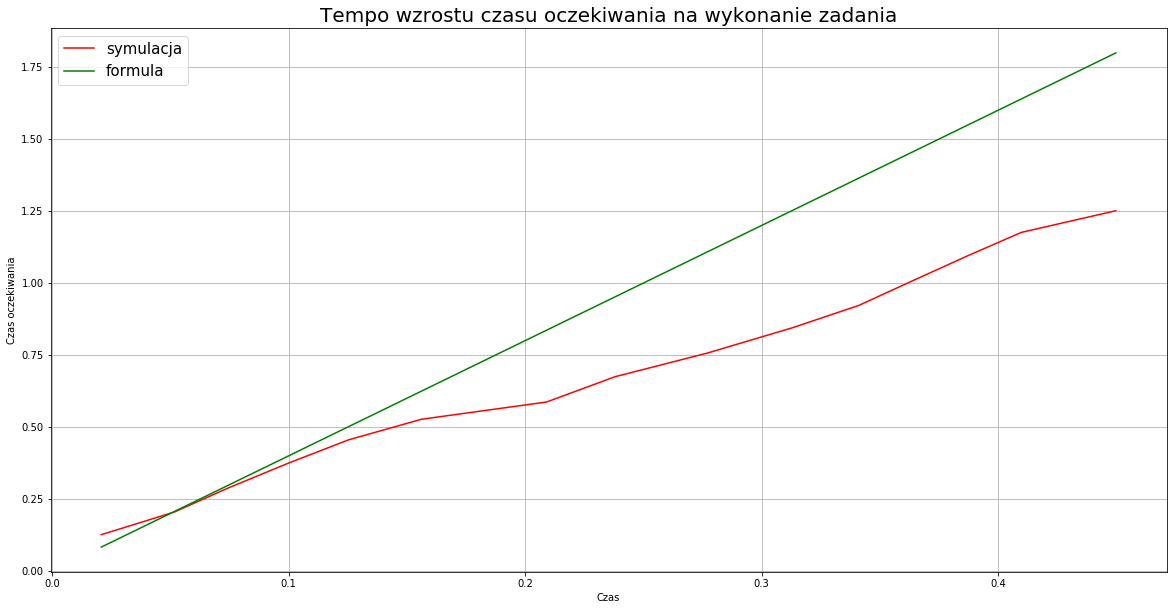

In [214]:
wait_time = get_wait_time(tasks)
plt.plot([task.start_time for task in tasks], wait_time, color='r', label='symulacja')
plt.xlabel('Czas')
plt.ylabel('Czas oczekiwania')
plt.grid()

plt.plot([task.start_time for task in tasks], [((la-ls)/ls) * task.start_time for task in tasks], color='g', label='formula')
plt.legend(loc='upper left', prop={'size': 15})
plt.title('Tempo wzrostu czasu oczekiwania na wykonanie zadania')
plt.show()